In [ ]:
# Regression task

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.utils.data as Data
import torch
from torchvision import models
from torchsummary import summary
from sklearn.model_selection import KFold


In [2]:
class CsvDataset(Dataset):

    def __init__(self, dataframe, transform=None):
        # read the dataframe file
        self.transform = transform
        self.data = dataframe
        # get columns names
        self.names = np.array( dataframe.columns )
        
    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # get item given idx, following code above
        sample = ( self.data.iloc[idx][self.names[0]], self.data.iloc[idx][self.names[1]] )
        if self.transform:
            sample = self.transform(sample)
        return sample


    
class ToTensor(object):
    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
    

    
    
    
class Model(nn.Module):
 
    def __init__(self, Ninp, Nhi1, Nhi2, Nout, drop=0.15):
        #initialize
        super(Model, self).__init__()       
        #1st hidden layer
        self.hl1 = nn.Linear(Ninp, Nhi1)  
        #1st dropout
        self.dr = nn.Dropout(drop)     
        #2nd hidden layer
        self.hl2 = nn.Linear(Nhi1, Nhi2)
        #output layer
        self.out = nn.Linear(Nhi2, Nout)  
        #activation function
        self.act = nn.ReLU()              
    
    def forward(self, x):
    #initialize vector containing training losses
        x_1 = self.act(self.hl1(x))     
        x_1 = self.dr(x_1)             
        x_2 = self.act(self.hl2(x_1))   
        x_2 = self.dr(x_2)             
        x   = self.out(x_2)            
        
        return x
    
    def train_step(self, train_loader, optimizer, loss_func, device, epoch):
        
        train_loss = [] 
        self.train()     
        
        for ii, s_batch in enumerate(train_loader):
            #import data, move to device 
            x_batch = s_batch[0].to(device) 
            #import labels, move to device
            label_b = s_batch[1].to(device)       
            
            for_out = self.forward(x_batch)      
            
            tr_loss = loss_func(for_out, label_b) 
            #back-propagation
            self.zero_grad()                      
            tr_loss.backward()
            
            optimizer.step()                      
            #save loss for batch
            ba_loss = tr_loss.detach().cpu().numpy()
            train_loss.append(ba_loss)            
            
        return train_loss
    
    
    
    def val_step(self, valid_loader, loss_func, device):
        #initialize vector containing validation losses
        val_loss = []
        #set evaluation mode
        self.eval()   
        
        with torch.no_grad():                      
            for s_batch in valid_loader:
                
                x_batch = s_batch[0].to(device)       
                label_b = s_batch[1].to(device)      
            
                for_out = self.forward(x_batch)       

                va_loss = loss_func(for_out, label_b) 

                ba_loss = va_loss.detach().cpu().numpy()
                val_loss.append(ba_loss)          
        
        return val_loss
    
    def fitting(self, train_loader, val_loader, optimizer, loss_func, param):

        train_loss_log = [] 
        val_loss_log = []
        
        for epoch in tqdm(range(param['num_epochs'])):
            # Training
            train_loss = self.train_step(train_loader, optimizer, loss_func, 
                                             param['device'], epoch)
            # Compute and store average training loss
            train_loss = np.mean(train_loss)
            train_loss_log.append(train_loss)
            
            valid_loss = self.val_step(val_loader, loss_func, param['device'])
            # Compute and store average validation loss
            valid_loss = np.mean(valid_loss)
            val_loss_log.append(valid_loss)
    
            
        return train_loss_log, val_loss_log
    
    def predicting(self, data_loader, device):
        #initialize vector containing predictions
        predicts = [] 
        #set evaluation mode
        self.eval()   
        
        with torch.no_grad(): 
            #disable gradient tracking
            for s_batch in data_loader:
                
                x_batch = s_batch[0].to(device) 
                
                for_out = self.forward(x_batch) 
                outputs = for_out.cpu().numpy()
                #save predictions
                predicts.append(outputs)        
        
        return np.array(predicts)
                
    def testing(self, test_loader, loss_func, device):
        #initialize vector containing accuracies
        accuracy = [] 
        self.eval()  
        
        with torch.no_grad():                   
            for s_batch in tqdm(test_loader):
                
                x_batch = s_batch[0].to(device)       
                label_b = s_batch[1].to(device)       
            
                for_out = self.forward(x_batch)       
                
                te_loss = loss_func(for_out, label_b) 
                ba_loss = te_loss.detach().cpu().numpy()
                
                accuracy.append(ba_loss.mean())       
        return np.array(accuracy).mean()
        

In [3]:
def random_params(params_dict):
    selected_params = {}
    for i in params_dict.keys():
        selected_params[i] = np.random.choice( params_dict[i] )
    return selected_params
# Avoiding weight leakage
def reset_weights(network):
    for layer in network.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
            
# Cross validation method for selecting optimal parameters through random search,         
# We divide the dataset into 5 folds for cross validation 
            
def cross_validation(par_dict, dataset, num_folds=5, n_models=1):
 
    model_params     = []
    train_loss_log = []
    val_loss_log   = []
    
    
    for i in range(n_models):
        # Define the K-fold Cross Validator
        kf = KFold(num_folds, shuffle=True)
        # random parameter selection 
        params = random_params(par_dict)
        model_params.append(params)
        # initialize support lists for losses on each k-fold
        tr_loss_kfold = np.zeros( (num_folds, params['num_epochs']) )
        va_loss_kfold = np.zeros( (num_folds, params['num_epochs']) )
        
        print('Model ', i+1)
        print('Network parameters:', params)
        
        for f, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            
            print('FOLD ', f+1)
            
            # sample elements in order to divide into validation/train datasets, build samplers.
            train_subsampler = Data.SubsetRandomSampler(train_idx)
            valid_subsampler = Data.SubsetRandomSampler(val_idx)
            
            b_size = int(params['batch_size'])
            train_loader = Data.DataLoader(dataset, batch_size=b_size, 
                                           sampler=train_subsampler)

            valid_loader = Data.DataLoader(dataset, batch_size=b_size, 
                                           sampler=valid_subsampler)    
            # initialization of the net
            Ninp, Nhi1, Nhi2, Nout = 1, params['Nhi1'], params['Nhi2'], 1
            model = Model(Ninp, Nhi1, Nhi2, Nout, params['dropout']).to(params['device'])
            model.apply(reset_weights)
    # select and set up optimizer
            if params['optimizer']=='sgd':
                optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9,
                               weight_decay=params['reg_param'])
            elif params['optimizer']=='adam':
                optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], 
                                 weight_decay=params['reg_param'])
            # training & validation 
            train_loss, val_loss = model.fitting(train_loader, valid_loader, optimizer, 
                                                          loss_func, params)
            # store validation and train losses per fold
            tr_loss_kfold[f, :] = train_loss 
            va_loss_kfold[f, :] = val_loss 
        # average loss on the k-folds
        print(np.mean(np.array(va_loss_kfold)))
        print(np.mean(np.array(tr_loss_kfold)))     
        val_loss_log.append( np.mean(np.array(va_loss_kfold)))
        train_loss_log.append( np.mean(np.array(tr_loss_kfold)) )
                            
        
    return model_params, train_loss_log, val_loss_log

In [4]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-08-28 13:38:58--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: 'regression_dataset/train_data.csv.1'

     0K ...                                                   100%  229K=0.02s

2022-08-28 13:38:59 (229 KB/s) - 'regression_dataset/train_data.csv.1' saved [3776/3776]

--2022-08-28 13:38:59--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: 'regression_dataset/test_data.csv.1'

     0K ..

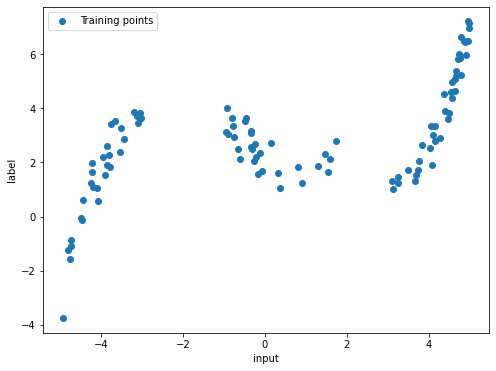

In [6]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df  = pd.read_csv('regression_dataset/test_data.csv')
fig = plt.figure(figsize=(8,6))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

In [8]:
train_dataset = CsvDataset(train_df, transform=ToTensor())
test_dataset  = CsvDataset(test_df, transform=ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

In [9]:
Ninp = 1
Nhi1 = 50
Nhi2 = 100
Nout = 1

model = Model(Ninp, Nhi1, Nhi2, Nout, 0.02)
print(model)

optimizer = optim.Adam(model.parameters(), lr=5e-4)
loss_func = nn.MSELoss()  
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
                               
params = {'num_epochs': 200, 'device': device}

train_loss, val_loss = model.fitting(train_dataloader, test_dataloader, optimizer, loss_func, params)

Model(
  (hl1): Linear(in_features=1, out_features=50, bias=True)
  (dr): Dropout(p=0.02, inplace=False)
  (hl2): Linear(in_features=50, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (act): ReLU()
)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.43it/s]


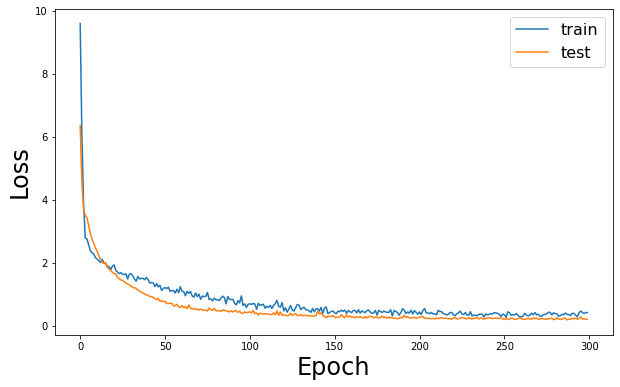

In [13]:
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel('Epoch', fontsize=24)
ax.set_ylabel('Loss', fontsize=24)

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='test')
plt.legend(fontsize=16)

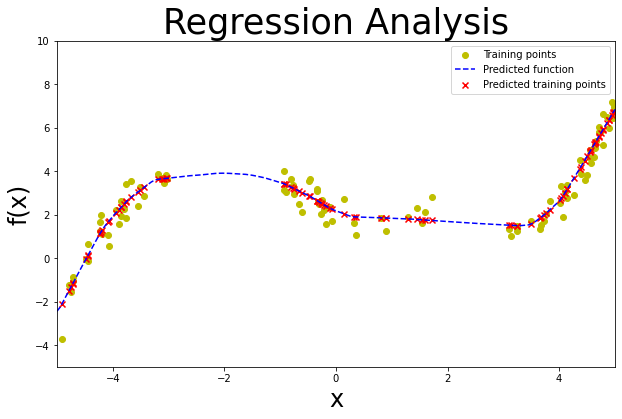

In [14]:
x = torch.unsqueeze(torch.tensor(train_df.input), dim=1).float()
y = torch.unsqueeze(torch.tensor(train_df.label), dim=1).float()

x_pred = torch.linspace(-5,5,1000)
x_pred = x_pred.to(device)
x_pred = x_pred.unsqueeze(-1)

model.to(device)

fig, ax = plt.subplots(figsize=(10,6))

plt.cla()
ax.set_title('Regression Analysis', fontsize=35)
ax.set_xlabel('x', fontsize=24)
ax.set_ylabel('f(x)', fontsize=24)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 10)



ax.scatter(train_df.input, train_df.label, color = 'y',label='Training points')

with torch.no_grad():
    prediction = model(x)     
with torch.no_grad():
    y_pred = model(x_pred)

ax.plot(x_pred.squeeze().cpu().numpy(), y_pred.squeeze().cpu().numpy(), 'b--',label='Predicted function')
ax.scatter(x.data.numpy(), prediction.data.numpy(), color = 'r', marker = 'x', label='Predicted training points')
plt.legend(loc='best')
plt.savefig('test_fitting_2.png')
plt.show()

In [10]:
params_dict = {"device"        : [device],
          "batch_size"    : [5, 10, 15],
          "dropout"       : [0.01, 0.03,  0.05],
          "num_epochs"    : [400, 600],
          "learning_rate" : [0.01, 0.001],
          "optimizer"     : ['sgd', 'adam'],
          "Nhi1"          : [10, 20, 50],
          "Nhi2"          : [100, 200, 300],
          "reg_param"     : [0.0001, 0.0003, 0.0005]
          }


model_params, train_loss_kf, val_loss_kf = cross_validation(params_dict, train_dataset, num_folds=5, n_models=50)


Model  1
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.01, 'num_epochs': 600, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 100, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:55<00:00,  5.18it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:52<00:00,  5.31it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:53<00:00,  5.30it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:55<00:00,  5.20it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:52<00:00,  5.31it/s]


0.8390993796636661
0.8130483589917421
Model  2
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.01, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:18<00:00,  5.08it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:17<00:00,  5.18it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:19<00:00,  5.01it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:15<00:00,  5.33it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:15<00:00,  5.27it/s]


0.4977428485378623
0.46447004649788143
Model  3
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.01, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 20, 'Nhi2': 300, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:46<00:00,  5.63it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:46<00:00,  5.66it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:44<00:00,  5.73it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:44<00:00,  5.75it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:43<00:00,  5.80it/s]


1.1615768860528866
1.2561579204102358
Model  4
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.03, 'num_epochs': 600, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:51<00:00,  3.50it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:49<00:00,  3.54it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:48<00:00,  3.56it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:47<00:00,  3.58it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:50<00:00,  3.51it/s]


0.5943984972238541
0.5814479804585377
Model  5
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 100, 'reg_param': 0.0003}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:21<00:00,  4.91it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.67it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.78it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.81it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.81it/s]


0.9915039221122861
1.0704452573210002
Model  6
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.05, 'num_epochs': 600, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 20, 'Nhi2': 300, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:48<00:00,  5.51it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:45<00:00,  5.68it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:50<00:00,  5.41it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:04<00:00,  4.82it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:03<00:00,  4.87it/s]


0.6663330577189723
0.7237470261454583
Model  7
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 300, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:41<00:00,  3.95it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.15it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:38<00:00,  4.07it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:38<00:00,  4.05it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:38<00:00,  4.07it/s]


0.5273229339271783
0.47658411853015425
Model  8
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 300, 'reg_param': 0.0003}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:15<00:00,  2.96it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:14<00:00,  2.97it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:15<00:00,  2.95it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:14<00:00,  2.98it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:12<00:00,  3.02it/s]


0.5954488035216927
0.5773170035257935
Model  9
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.01, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 20, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.59it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.68it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.60it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.62it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.59it/s]


2.3377996536791326
2.449795990765095
Model  10
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.03, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 20, 'Nhi2': 100, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:23<00:00,  4.18it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:23<00:00,  4.17it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:26<00:00,  4.10it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:25<00:00,  4.13it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:24<00:00,  4.14it/s]


0.49925481726229193
0.4573294693281253
Model  11
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 20, 'Nhi2': 100, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.68it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.67it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.68it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.69it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.67it/s]


0.7952897610105574
0.8058827981501818
Model  12
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.03, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 50, 'Nhi2': 200, 'reg_param': 0.0003}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:53<00:00,  3.47it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:52<00:00,  3.49it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:50<00:00,  3.52it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:49<00:00,  3.54it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:49<00:00,  3.53it/s]


3.165902425567309
3.398399113893509
Model  13
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 50, 'Nhi2': 200, 'reg_param': 0.0003}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:41<00:00,  3.95it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:36<00:00,  4.13it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:39<00:00,  4.00it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:39<00:00,  4.00it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:39<00:00,  4.01it/s]


0.6242121759727597
0.7037660158798098
Model  14
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.01, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 20, 'Nhi2': 100, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.66it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.64it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.66it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.64it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.60it/s]


0.5393671684712171
0.4883839360177517
Model  15
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.05, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 20, 'Nhi2': 200, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:18<00:00,  3.03it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:17<00:00,  3.03it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:23<00:00,  2.95it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:47<00:00,  2.63it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:47<00:00,  2.64it/s]


0.48225299043705067
0.5019240849763155
Model  16
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.03, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 10, 'Nhi2': 100, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:07<00:00,  3.21it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:51<00:00,  3.49it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:50<00:00,  3.52it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:54<00:00,  3.44it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:52<00:00,  3.49it/s]


3.3465152526696524
3.5570400677522023
Model  17
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.01, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 50, 'Nhi2': 100, 'reg_param': 0.0003}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.78it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.77it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:24<00:00,  4.76it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.77it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:24<00:00,  4.75it/s]


0.7990136978402734
0.8282245034724474
Model  18
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 50, 'Nhi2': 100, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.42it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.34it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.49it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.47it/s]


2.16172138312459
2.1520519410073757
Model  19
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 20, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.80it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.77it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.80it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.79it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.78it/s]


0.7707862451970577
0.8487027146667242
Model  20
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.01, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 50, 'Nhi2': 200, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:56<00:00,  3.44it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:56<00:00,  3.43it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:57<00:00,  3.40it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:56<00:00,  3.43it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:57<00:00,  3.40it/s]


0.7510238344296813
0.6874069518148899
Model  21
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 10, 'Nhi2': 100, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:22<00:00,  4.85it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:22<00:00,  4.85it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:22<00:00,  4.85it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:22<00:00,  4.86it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:21<00:00,  4.91it/s]


0.8538856211006641
0.912648632273078
Model  22
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 10, 'Nhi2': 100, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.63it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.64it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.61it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.47it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.20it/s]


0.9337318825572729
1.0141922201067208
Model  23
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.05, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 10, 'Nhi2': 300, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:11<00:00,  4.56it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:08<00:00,  4.67it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:08<00:00,  4.66it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:05<00:00,  4.78it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:21<00:00,  4.24it/s]


2.118427448540926
2.2271412242452304
Model  24
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 20, 'Nhi2': 200, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.23it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:34<00:00,  4.21it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:39<00:00,  4.02it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:33<00:00,  4.29it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:35<00:00,  4.19it/s]


0.5029592010229826
0.5093953539282083
Model  25
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 20, 'Nhi2': 300, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:22<00:00,  2.81it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:22<00:00,  2.80it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:23<00:00,  2.78it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:22<00:00,  2.80it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:22<00:00,  2.80it/s]


0.6628232722654939
0.6617209939733147
Model  26
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 10, 'Nhi2': 200, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.49it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.50it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.55it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.50it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.50it/s]


2.0891289464533327
2.5057463340163233
Model  27
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.05, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:30<00:00,  3.98it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:31<00:00,  3.97it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:30<00:00,  3.98it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:30<00:00,  3.99it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:29<00:00,  4.02it/s]


0.4692996402680874
0.483602615326643
Model  28
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.01, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 20, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:17<00:00,  2.90it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:19<00:00,  2.86it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:18<00:00,  2.89it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:19<00:00,  2.87it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:17<00:00,  2.90it/s]


0.6247214955687523
0.579208896458149
Model  29
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.01, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 20, 'Nhi2': 300, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:06<00:00,  4.73it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:15<00:00,  4.42it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:15<00:00,  4.42it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:16<00:00,  4.41it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:15<00:00,  4.42it/s]


1.1476392228802046
1.278979206820329
Model  30
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 50, 'Nhi2': 200, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.41it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.39it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.38it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


2.3066000776141884
2.405223564982414
Model  31
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 100, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.42it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.42it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.40it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.44it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.42it/s]


0.5689828741177917
0.5540401713326574
Model  32
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.01, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 20, 'Nhi2': 300, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:56<00:00,  3.44it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:56<00:00,  3.43it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:56<00:00,  3.44it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:54<00:00,  3.49it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:58<00:00,  3.38it/s]


0.700677729010582
0.670114911057055
Model  33
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 50, 'Nhi2': 200, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:22<00:00,  2.80it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:23<00:00,  2.78it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:22<00:00,  2.81it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:21<00:00,  2.83it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:22<00:00,  2.81it/s]


0.5312576586604119
0.5658303504735231
Model  34
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 20, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:20<00:00,  4.94it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:20<00:00,  4.96it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:20<00:00,  4.99it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:21<00:00,  4.93it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:20<00:00,  4.98it/s]


1.8241341667324305
1.881735125184059
Model  35
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 100, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.54it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.59it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.55it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.60it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.57it/s]


0.5561332307159901
0.5914290138408542
Model  36
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.53it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.55it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.53it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.54it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.51it/s]


1.018562875494361
1.094482290804386
Model  37
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 10, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.68it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.65it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.68it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.70it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.68it/s]


0.7673138474225998
0.8611449096351862
Model  38
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 50, 'Nhi2': 300, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:22<00:00,  4.85it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.82it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:22<00:00,  4.85it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:22<00:00,  4.82it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:22<00:00,  4.86it/s]


0.7478136654496192
0.7916389724388718
Model  39
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.03, 'num_epochs': 600, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 50, 'Nhi2': 300, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:21<00:00,  4.24it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:18<00:00,  4.33it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:19<00:00,  4.31it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:21<00:00,  4.24it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:20<00:00,  4.27it/s]


0.5548005834569534
0.5707500178863605
Model  40
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.01, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 300, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:13<00:00,  4.48it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:13<00:00,  4.49it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:14<00:00,  4.46it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:14<00:00,  4.47it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:14<00:00,  4.45it/s]


0.44631165446341037
0.40193905467291674
Model  41
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.01, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 10, 'Nhi2': 300, 'reg_param': 0.0003}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:01<00:00,  4.95it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:02<00:00,  4.91it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:01<00:00,  4.95it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:01<00:00,  4.95it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:01<00:00,  4.93it/s]


3.548283267279466
3.123989273707072
Model  42
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 300, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.53it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.53it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.51it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.47it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.51it/s]


0.8870420304015278
0.8140421995073557
Model  43
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.01, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'sgd', 'Nhi1': 50, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:11<00:00,  4.57it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:10<00:00,  4.59it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:12<00:00,  4.53it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:12<00:00,  4.53it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:11<00:00,  4.55it/s]


2.0010550444523494
2.075489275286595
Model  44
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.05, 'num_epochs': 600, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 20, 'Nhi2': 100, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:24<00:00,  4.15it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:24<00:00,  4.16it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:23<00:00,  4.18it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:22<00:00,  4.22it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:23<00:00,  4.19it/s]


0.7080911955436071
0.7851530588914951
Model  45
Network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 50, 'Nhi2': 200, 'reg_param': 0.0003}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.49it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.45it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.44it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.36it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.33it/s]


0.6982430458962917
0.7407628118023276
Model  46
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.03, 'num_epochs': 600, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 10, 'Nhi2': 300, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:11<00:00,  4.56it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:12<00:00,  4.54it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:12<00:00,  4.52it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:12<00:00,  4.53it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:11<00:00,  4.56it/s]


0.6407161593586207
0.6676535501629114
Model  47
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.05, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 200, 'reg_param': 0.0005}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.09it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:38<00:00,  4.08it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.11it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.10it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:37<00:00,  4.09it/s]


0.8714039433076978
0.9584176228046417
Model  48
Network parameters: {'device': device(type='cpu'), 'batch_size': 5, 'dropout': 0.01, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'adam', 'Nhi1': 50, 'Nhi2': 300, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:29<00:00,  2.68it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:27<00:00,  2.71it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:27<00:00,  2.72it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:32<00:00,  2.63it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:26<00:00,  2.73it/s]


0.5596274136975408
0.4768626861199737
Model  49
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.03, 'num_epochs': 600, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 20, 'Nhi2': 100, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:10<00:00,  4.61it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:09<00:00,  4.62it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:09<00:00,  4.64it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:08<00:00,  4.66it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:08<00:00,  4.69it/s]


0.704092388505737
0.7283363588203986
Model  50
Network parameters: {'device': device(type='cpu'), 'batch_size': 10, 'dropout': 0.03, 'num_epochs': 400, 'learning_rate': 0.001, 'optimizer': 'sgd', 'Nhi1': 20, 'Nhi2': 200, 'reg_param': 0.0001}
FOLD  1


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.59it/s]


FOLD  2


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.60it/s]


FOLD  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.59it/s]


FOLD  4


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.58it/s]


FOLD  5


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.59it/s]

0.6863734778538346
0.7784237896203995


Best network parameters: {'device': device(type='cpu'), 'batch_size': 15, 'dropout': 0.01, 'num_epochs': 600, 'learning_rate': 0.01, 'optimizer': 'adam', 'Nhi1': 10, 'Nhi2': 300, 'reg_param': 0.0005} 0.44631165446341037


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:40<00:00,  2.72it/s]


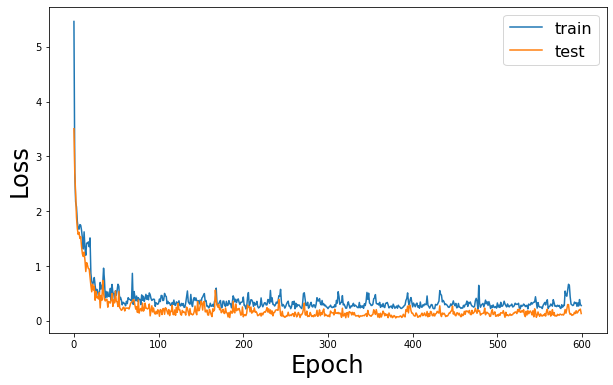

In [11]:
# Best model
best_params = model_params[np.argmin(val_loss_kf)]
print('Best network parameters:', best_params,val_loss_kf[np.argmin(val_loss_kf)])

b_size = int(best_params['batch_size'])
# train dataloaders
train_dataloader = Data.DataLoader(train_dataset, batch_size=b_size, shuffle=True)
#test dataloader 
val_dataloader  = Data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
loss_func = nn.MSELoss()  
# initialization of the net
Ninp, Nhi1, Nhi2, Nout = 1, best_params['Nhi1'], best_params['Nhi2'], 1
model = Model(Ninp, Nhi1, Nhi2, Nout, best_params['dropout']).to(device)

# select and set up optimizer
if best_params['optimizer']=='sgd':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'], momentum=0.9,
                   weight_decay=best_params['reg_param'])
elif best_params['optimizer']=='adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], 
                     weight_decay=best_params['reg_param'])
        

best_train_loss, best_val_loss = model.fitting(train_dataloader, val_dataloader, optimizer, 
                                                        loss_func, best_params)

fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel('Epoch', fontsize=24)
ax.set_ylabel('Loss', fontsize=24)

plt.plot(best_train_loss, label='train')
plt.plot(best_val_loss, label='test')
plt.legend(fontsize=16)

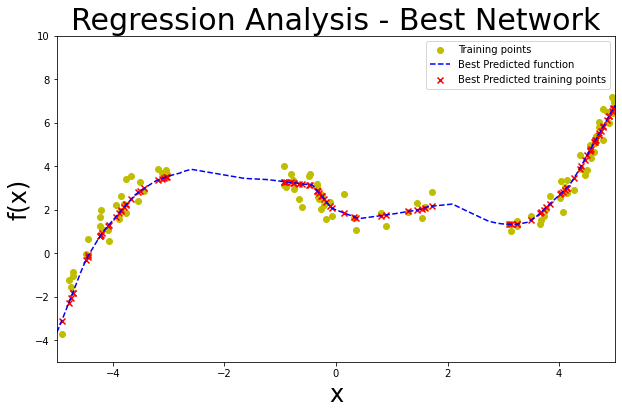

<Figure size 432x288 with 0 Axes>

In [12]:
# training dataset: convert to tensors and use Variable from torch.autograd
x = torch.unsqueeze(torch.tensor(train_df.input), dim=1).float()
y = torch.unsqueeze(torch.tensor(train_df.label), dim=1).float()

x_pred = torch.linspace(-5,5,1000)
x_pred = x_pred.to(device)
x_pred = x_pred.unsqueeze(-1)

model.to(device)

fig, ax = plt.subplots(figsize=(10,6))

plt.cla()
ax.set_title('Regression Analysis - Best Network', fontsize=30)
ax.set_xlabel('x', fontsize=24)
ax.set_ylabel('f(x)', fontsize=24)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 10)

ax.scatter(train_df.input, train_df.label, color = 'y',label='Training points')
prediction = model(x)     
with torch.no_grad():
    y_pred = model(x_pred)

ax.plot(x_pred.squeeze().cpu().numpy(), y_pred.squeeze().cpu().numpy(), 'b--',label='Best Predicted function')
ax.scatter(x.data.numpy(), prediction.data.numpy(), color = 'r', marker = 'x', label='Best Predicted training points')
plt.legend(loc='best')
plt.show()
plt.savefig('best_net_fitting.png')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.38it/s]


Average testing loss for the best network: 0.1336599


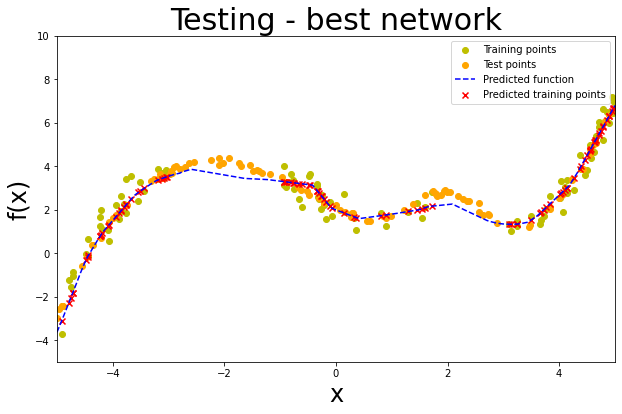

In [13]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'best_model_parameters_reg.torch')
torch.save(optimizer.state_dict(), 'optimizer_state_reg.torch')

####### Best networks testing
### Reload the network state

top_model = Model(1, best_params['Nhi1'], best_params['Nhi2'], 1, best_params['dropout'])
# Reload the optimizer state
if best_params['optimizer']=='sgd':
    optimizer = optim.SGD(top_model.parameters(), lr=best_params['learning_rate'], momentum=0.9,
                   weight_decay=best_net['reg_param'])
elif best_params['optimizer']=='adam':
    optimizer = optim.Adam(top_model.parameters(), lr=best_params['learning_rate'], 
                     weight_decay=best_params['reg_param'])
# Load the state dict previously saved
model_state = torch.load("best_model_parameters_reg.torch")
# Update the network parameters
top_model.load_state_dict(model_state)
opt_state_dict = torch.load( 'optimizer_state_reg.torch')
optimizer.load_state_dict(opt_state_dict)


loss_func = nn.MSELoss()
final_test_loss = top_model.testing(test_dataloader, loss_func, device)
print('Average testing loss for the best network:', final_test_loss)
# for plotting the predicted function
x_pred = torch.linspace(-5,5,1000)
x_pred = x_pred.to(device)
x_pred = x_pred.unsqueeze(-1)

top_model.to(device)

fig, ax = plt.subplots(figsize=(10,6))

plt.cla()
ax.set_title('Testing - best network', fontsize=30)
ax.set_xlabel('x', fontsize=24)
ax.set_ylabel('f(x)', fontsize=24)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 10)

ax.scatter(train_df.input, train_df.label, color = 'y', label='Training points')
ax.scatter(test_df.input, test_df.label, color = 'orange', label='Test points')

prediction = top_model(x)  
# Network output
with torch.no_grad():
    y_pred = top_model(x_pred)

ax.plot(x_pred.squeeze().cpu().numpy(), y_pred.squeeze().cpu().numpy(), 'b--', label='Predicted function')
ax.scatter(x.data.numpy(), prediction.data.numpy(), color = 'r', marker = 'x', label='Predicted training points')
plt.legend(loc='best')
plt.savefig('best_net_testing.png')
plt.show()

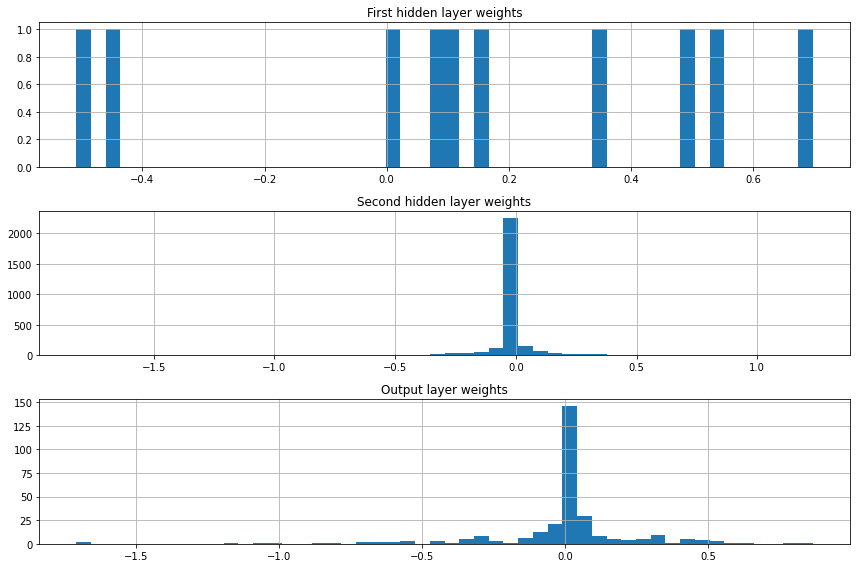

In [14]:
#####  Weight Analysis
# First hidden layer
h1_w = top_model.hl1.weight.data.cpu().numpy()
h1_b = top_model.hl1.bias.data.cpu().numpy()
# Second hidden layer
h2_w = top_model.hl2.weight.data.cpu().numpy()
h2_b = top_model.hl2.bias.data.cpu().numpy()
# Output layer
out_w = top_model.out.weight.data.cpu().numpy()
out_b = top_model.out.bias.data.cpu().numpy()


# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

torch.Size([10])
torch.Size([300])
torch.Size([1])


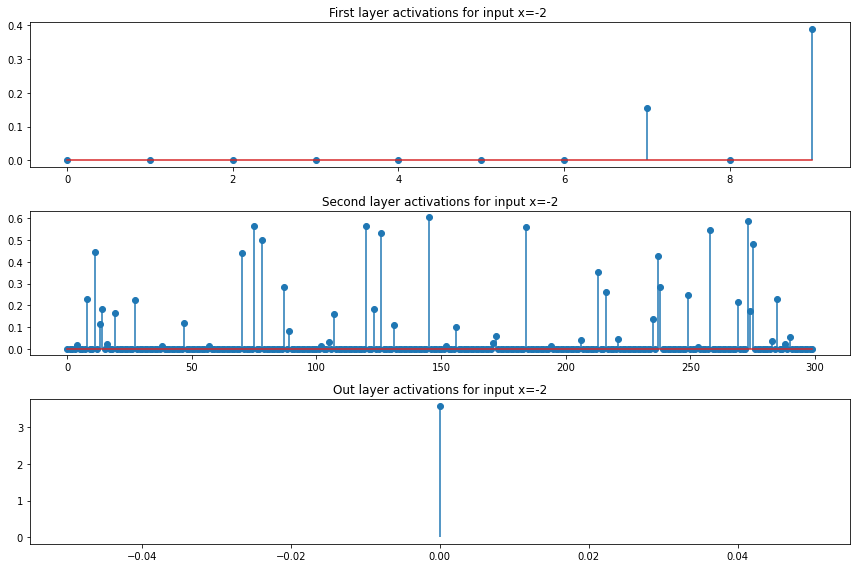

In [15]:
##### Activations Analysis 
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
# Register hook
handle_hook_hl1 = top_model.hl1.register_forward_hook(get_activation('hl1'))
handle_hook_hl2 = top_model.hl2.register_forward_hook(get_activation('hl2'))
handle_hook_out = top_model.out.register_forward_hook(get_activation('out'))

x = torch.tensor([-2]).float()


with torch.no_grad():
    y = top_model(x)
    
print(activation['hl1'].size())
print(activation['hl2'].size())
print(activation['out'].size())

# Remove hook
handle_hook_hl1 .remove()
handle_hook_hl2 .remove()
handle_hook_out .remove()

fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].stem(torch.relu(activation['hl1']).cpu().numpy(), use_line_collection=True)
axs[0].set_title('First layer activations for input x=-2 ')
axs[1].stem(torch.relu(activation['hl2']).cpu().numpy(), use_line_collection=True)
axs[1].set_title('Second layer activations for input x=-2')
axs[2].stem(torch.relu(activation['out']).cpu().numpy(), use_line_collection=True)
axs[2].set_title('Out layer activations for input x=-2')
plt.tight_layout()
plt.show()



torch.Size([10])
torch.Size([300])
torch.Size([1])


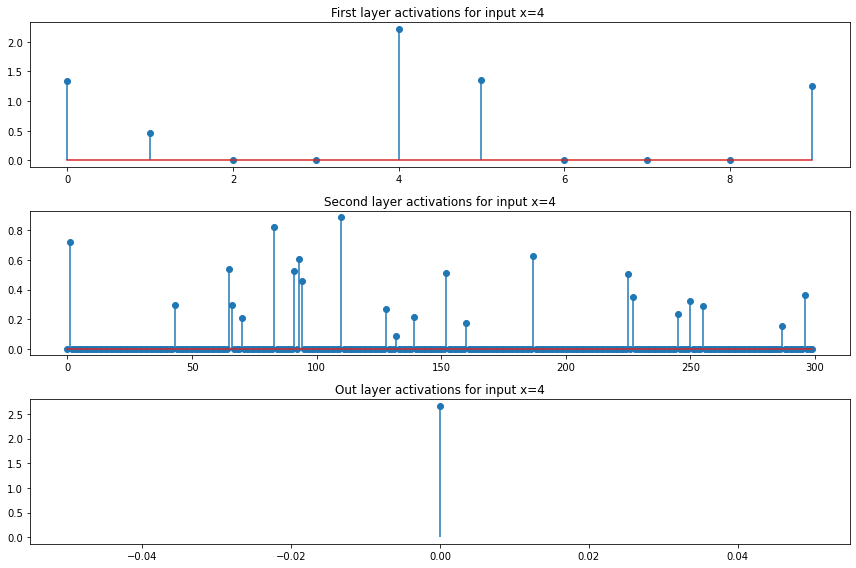

In [16]:
handle_hook_hl1 = top_model.hl1.register_forward_hook(get_activation('hl1'))
handle_hook_hl2 = top_model.hl2.register_forward_hook(get_activation('hl2'))
handle_hook_out = top_model.out.register_forward_hook(get_activation('out'))

x = torch.tensor([4]).float()


with torch.no_grad():
    y = top_model(x)
    
print(activation['hl1'].size())
print(activation['hl2'].size())
print(activation['out'].size())
handle_hook_hl1 .remove()
handle_hook_hl2 .remove()
handle_hook_out .remove()

fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].stem(torch.relu(activation['hl1']).cpu().numpy(), use_line_collection=True)
axs[0].set_title('First layer activations for input x=4 ')
axs[1].stem(torch.relu(activation['hl2']).cpu().numpy(), use_line_collection=True)
axs[1].set_title('Second layer activations for input x=4')
axs[2].stem(torch.relu(activation['out']).cpu().numpy(), use_line_collection=True)
axs[2].set_title('Out layer activations for input x=4')
plt.tight_layout()
plt.show()

